# 4. Alternate Method: ISOMAP

Given Pairwise Dissimilarity between Data Points, Reconstruct a low-dimensional distance "map" that preserves distance.

Refer to paper by _Tenenbaum, Joshua B. A Global Geometric Framework for Nonlinear Dimensionality Reduction. \_Science_, 290:2319-2323, 2000.\_

Often used to find manifolds in high-dimension space, such as the classic 'swiss-roll' manifold.


Import Packages


In [1]:
import sys

sys.path.append("..")

import matplotlib.pyplot as plt
import numpy as np

from numba import jit
from sklearn import cluster, neighbors
from scipy import sparse
from scipy.sparse.csgraph import shortest_path
import scipy.sparse.linalg as ll
from utils.utils import elbow_diagram, run_kmeans

Load data


In [2]:
A = np.load("../data/A.npy")
trim_seqs = np.load("../data/trim_seqs.npy")

In [3]:
A[:5, :5]

array([[ 0,  0, 44,  1, 18],
       [ 0,  0, 44,  1, 18],
       [44, 44,  0, 43, 32],
       [ 1,  1, 43,  0, 17],
       [18, 18, 32, 17,  0]], dtype=int16)

Find the shortest path between nodes in k-Nearest Neighbor network


In [4]:
k_nn = 120
knn_distance = neighbors.kneighbors_graph(
    A, n_neighbors=k_nn, include_self=False, mode="distance"
)
A_nn = np.asarray(sparse.csc_matrix.todense(knn_distance))

D2 = shortest_path(A_nn)
D2[:1, :11]

array([[   0.        ,   40.        ,  543.20346096,   20.        ,
         297.88756268,  541.84499629,  573.12714494, 1030.74490762,
          39.44616585,  573.12714494, 1070.09697264]])

Fix D2 shortest path where the graph is not connected


In [5]:
max_sp = np.nanmax(D2[np.isfinite(D2)])
D2 = np.where(np.isinf(D2), max_sp * 1, D2)

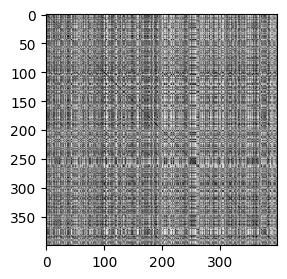

In [6]:
plt.figure(figsize=(3, 3))
plt.tight_layout()
plt.imshow(D2, cmap="gray")
plt.savefig(rf"../plots/geod_unsorted.png")
plt.show()

Calculate centering matrix $H$


In [7]:
m = D2.shape[0]
H = np.eye(m) - 1 / m * np.ones((m, m))
H[:5, :5]

array([[ 0.9975, -0.0025, -0.0025, -0.0025, -0.0025],
       [-0.0025,  0.9975, -0.0025, -0.0025, -0.0025],
       [-0.0025, -0.0025,  0.9975, -0.0025, -0.0025],
       [-0.0025, -0.0025, -0.0025,  0.9975, -0.0025],
       [-0.0025, -0.0025, -0.0025, -0.0025,  0.9975]])

Center the geodesic distance matrix $D2$ by $H$


In [8]:
G = -1 / 2 * H @ np.square(D2) @ H
G[:5, :5]

array([[325447.6735506 , 324647.6735506 ,  45796.81499786,
        315136.36060047, 148793.01361106],
       [324647.6735506 , 325447.6735506 ,  45796.81499786,
        315136.36060047, 148793.01361106],
       [ 64699.23583362,  64699.23583362, 129231.47972008,
         64301.55784384,  59182.67833328],
       [319080.81064575, 319080.81064575,  44875.95209301,
        309169.49769562, 147277.15070621],
       [175674.80923656, 175674.80923656, -23175.07404073,
        170214.49628642,  87757.14929701]])

Find the $n_{eigs}$ number of leading eigenvalues and eigenvectors


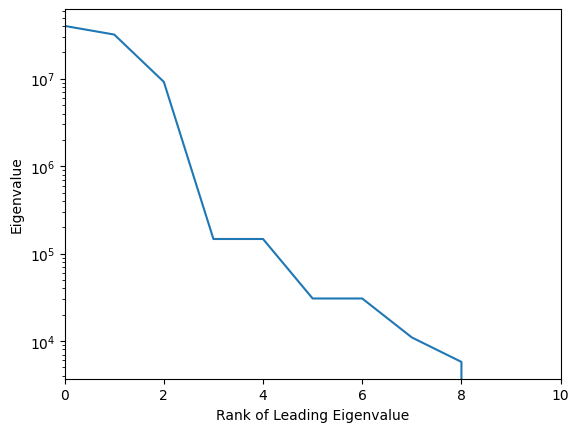

In [9]:
n_eigs = 15
lam, u = ll.eigs(G, k=n_eigs)
lam = lam.real
u = u.real
lam2 = lam.copy()
lam2.sort()
lam2 = lam2[::-1]
plt.plot(lam2)
plt.yscale("log")
plt.xlim(0, 10)
plt.xlabel("Rank of Leading Eigenvalue")
plt.ylabel("Eigenvalue")
plt.show()

Calculate the reduced representation matrix $Z$


In [10]:
Z_T = u @ np.diag(lam)
Z = Z_T.T
print(Z.shape)
Z_T[:5, :5]

(15, 400)


array([[ 7.70596007e+05, -1.15194386e+06,  2.84098338e+05,
        -1.19462406e+04,  4.87497148e+03],
       [ 7.70596007e+05, -1.15194386e+06,  2.84098338e+05,
        -1.19462406e+04,  4.87497148e+03],
       [ 5.68144378e+05, -4.43776112e+05, -8.24401304e+05,
        -3.48078369e+03, -9.20384466e+02],
       [ 7.56045597e+05, -1.13110626e+06,  2.79358353e+05,
        -7.60530947e+03,  2.41610944e+03],
       [ 4.12423201e+05, -4.20376443e+05,  5.29242341e+05,
        -5.33980561e+04,  3.18762353e+04]])

Run $k$-means clustering to find $k$ with best fit.


In [11]:
k_min = 1  # 0-index
k_max = 10
n_dim = 2
norm_inertia = [
    run_kmeans(k, Z_T, n_dim, n_init=25).inertia_ for k in range(k_min, k_max)
]
ct = [*range(k_min, k_max)]

c:\Users\Josh.Meehl\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Josh.Meehl\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


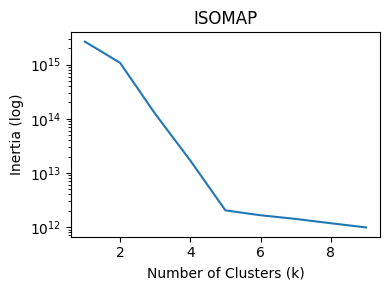

In [12]:
elbow_diagram(
    norm_inertia, ct, log=True, filename="../plots/elbow_isomap.png", title="ISOMAP"
)

$k=5$ Appears to fit the data best.

Get cluster labels:


In [13]:
k = 7
km = cluster.KMeans(n_clusters=k).fit(Z_T[:, :n_eigs])
labels = km.labels_

c:\Users\Josh.Meehl\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Visualize labeled clusters


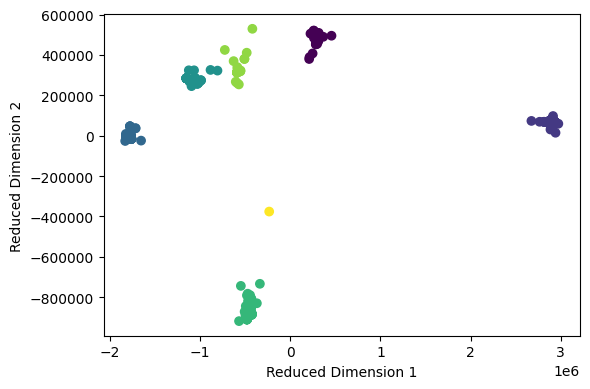

In [14]:
i = 1
j = 2
fig, ax = plt.subplots(figsize=(6, 4))
plt.scatter((Z_T[:, i]), (Z_T[:, j]), c=labels)

ax.set_xlabel(f"Reduced Dimension {i}")
ax.set_ylabel(f"Reduced Dimension {j}")
# ax.set_title(f"2D Reduced Representation")
plt.tight_layout()
plt.savefig(rf"../plots/2D_isomap_{k}.png")
plt.show()

Look at frequency of occurances


In [15]:
unique, frequency = np.unique(labels, return_counts=True)
print(unique, frequency)

[0 1 2 3 4 5 6] [80 80 80 57 79 23  1]


Sort sequences and display


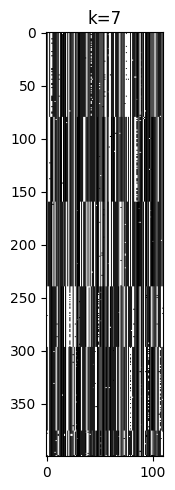

In [16]:
sort_seqs = trim_seqs[labels.argsort(), :]

plt.figure(figsize=(2, 5))
plt.title(f"k={k}")
plt.imshow(sort_seqs, cmap="gray")
plt.tight_layout()
plt.savefig(rf"../plots/sequences_sorted_iso_{k}.png")
plt.show()

Visualize Adjacency Matrix $D2$


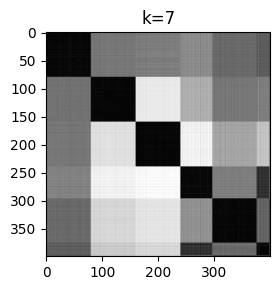

In [17]:
D2_sort = D2[labels.argsort(), :][:, labels.argsort()]

plt.figure(figsize=(3, 3))
plt.title(f"k={k}")
plt.tight_layout()
plt.imshow(D2_sort, cmap="gray")
plt.savefig(rf"../plots/adj_sorted_iso_{k}.png")
plt.show()

## Conclusion

The ISOMAP approach shows differentiation between clusters of data. 5 clusters seem to fit the data best, but also 7 clusters works well do subdivide the most heterogeneous cluster.

The Spectral Clustering results are close, with 1 mismatch.

This data also indicates that two of the cluster are more closely related, indicating 4 primary variants with one variant having 2 distinct sub-variants. Several other clusters also show less distinct subclusters.

Known genomic sequence data should be used to validate this method prior to use.
